**STEP-1**

In [2]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2M  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [3]:
#I am using the zipped file to upload the whole dataset from the local computer
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [4]:
# Now I will be unzipping the whole dataset
import os
import zipfile
uploaded_filename = 'archive (1).zip'


if os.path.exists(uploaded_filename):
  with zipfile.ZipFile(uploaded_filename, 'r') as zip_ref:
      zip_ref.extractall('.')
  print(f"Successfully unzipped {uploaded_filename}")
else:
  print(f"Error: {uploaded_filename} not found.")

Successfully unzipped archive (1).zip


In [5]:
testpath= r'/content/modified-dataset/test'
trainpath= r'/content/modified-dataset/train'
validpath = r'/content/modified-dataset/val'

In [6]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [7]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [8]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = datatrain.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = datatest.map(lambda x, y: (x/255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [11]:
x_train = []
y_train = []
for images, labels in datatrain:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)


In [12]:
from sklearn.model_selection import train_test_split

# Split training data into training + validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)


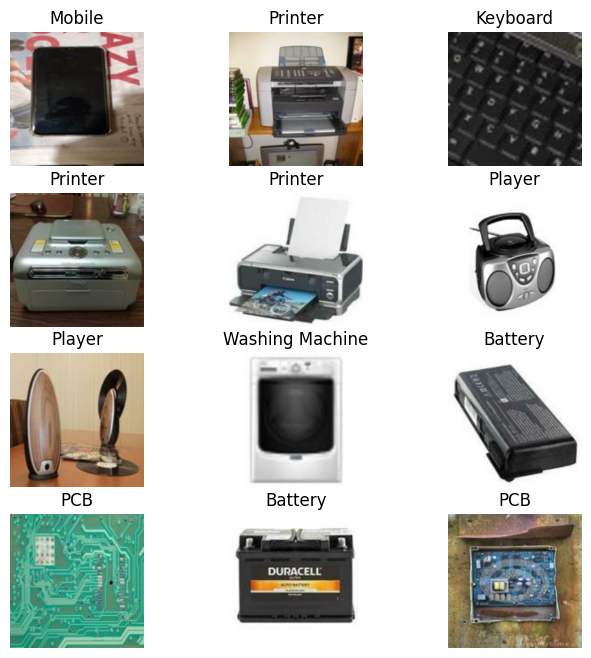

In [13]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(8, 8))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


In [14]:
#now we check if the dataset is balanced
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Sort classes by count for better visualization
    sorted_indices = np.argsort(counts)[::-1]
    class_names = [class_names[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    # # Create the plot
    # plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    # sns.barplot(x=class_names, y=counts, palette="viridis")
    # plt.title(title)
    # plt.xlabel("Class")
    # plt.ylabel("Number of Items")
    # plt.xticks(rotation=45, ha="right") # Rotate labels for readability
    # plt.tight_layout() # Adjust layout to prevent labels overlapping
    # plt.show() # Display the plot


    # Create the bar plot
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.bar(class_names, counts, color='purple')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    #plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot





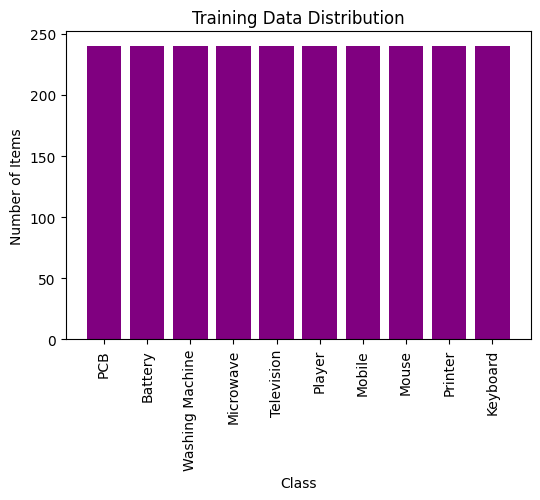

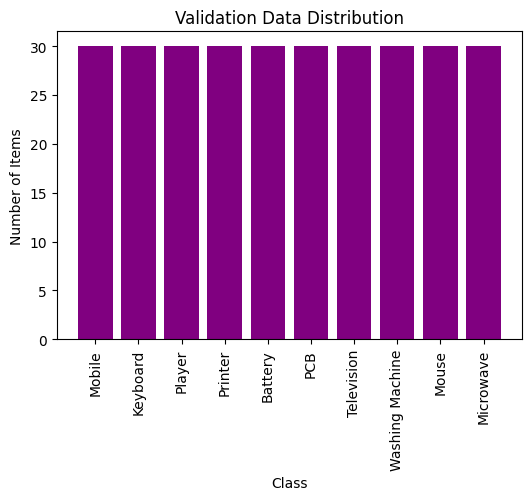

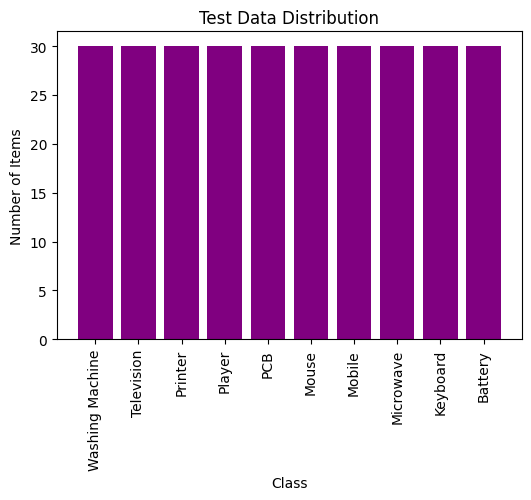

In [15]:
#here we get a perfectly balanced dataset, so we do not need to balance it

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

**STEP-2**

In [16]:
#Here we change the images and augment the data however we require
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [17]:
base_model = tf.keras.applications.EfficientNetV2M(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [18]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
#this means when accuracy starts becoming constant or reducing then the early stop is implemented

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [19]:
num_classes = len(class_names) # Define num_classes using the length of the class_names list

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # if you want augmentation in the model
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# Set the number of epochs to train the model
epochs = 20

# Compile the model (ensure it's compiled before training)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 205s 993ms/step - accuracy: 0.6871 - loss: 1.0214 - val_accuracy: 0.8900 - val_loss: 0.3118
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 845ms/step - accuracy: 0.8674 - loss: 0.4363 - val_accuracy: 0.9167 - val_loss: 0.3077
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 851ms/step - accuracy: 0.9063 - loss: 0.2917 - val_accuracy: 0.9033 - val_loss: 0.2870
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 852ms/step - accuracy: 0.9350 - loss: 0.2056 - val_accuracy: 0.9200 - val_loss: 0.2573
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 845ms/step - accuracy: 0.9483 - loss: 0.1758 - val_accuracy: 0.9367 - val_loss: 0.1784
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 847ms/step - accuracy: 0.9547 - loss: 0.1331 - val_accuracy: 0.9500 - val_loss: 0.2274
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 859ms/step - accuracy: 0.9595 - loss: 0.1277 - val_accuracy: 0.9167 - val_loss: 0.2594
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 845ms/step - accuracy: 0.9535 - loss: 0.1632 - val_acc

In [21]:
model.summary() # Print the architecture summary of the  model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 7, 7, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,432,068 (592.93 MB)

 Trainable params: 51,134,434 (195.06 MB)

 Non-trainable params: 2,028,764 (7.74 MB)

 Optimizer params: 102,268,870 (390.12 MB)

In [22]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-m"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 112, 112,  │      5,184 │ block1b_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 112, 112,  │         96 │ block1c_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 112, 112,  │          0 │ block1c_project_

 Total params: 53,150,388 (202.75 MB)

 Trainable params: 51,121,624 (195.01 MB)

 Non-trainable params: 2,028,764 (7.74 MB)

In [23]:
acc = history.history['accuracy']           # ✅ Lowercase
val_acc = history.history['val_accuracy']   # ✅ Lowercase
loss = history.history['loss']
val_loss = history.history['val_loss']


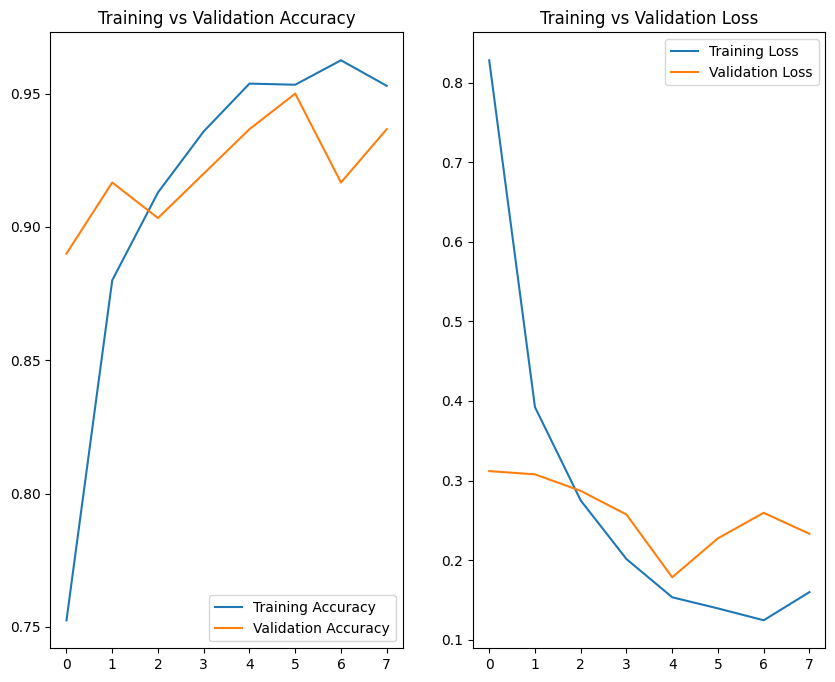

In [24]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [25]:
x_test = []
y_test = []
for images, labels in datatest:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)


In [26]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8911 - loss: 0.2341
Test accuracy is 0.9167, Test loss is 0.1983


In [27]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 997ms/step
[[25  0  0  0  0  2  3  0  0  0]
 [ 3 26  0  0  0  1  0  0  0  0]
 [ 0  0 28  0  0  0  0  1  0  1]
 [ 0  0  0 26  1  2  1  0  0  0]
 [ 0  0  0  0 28  1  0  1  0  0]
 [ 1  0  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  0  0 27  2  1  0]
 [ 0  0  0  0  0  0  1 29  0  0]
 [ 0  0  2  0  0  0  0  0 27  1]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       1.00      0.87      0.93        30
           2       0.93      0.93      0.93        30
           3       1.00      0.87      0.93        30
           4       0.97      0.93      0.95        30
           5       0.83      0.97      0.89        30
           6       0.84      0.90      0.87        30
           7       0.88      0.97      0.92        30
           8       0.96      0.90      0.93        30
           9       0.94      1.00      0.97        30

    accuracy                   

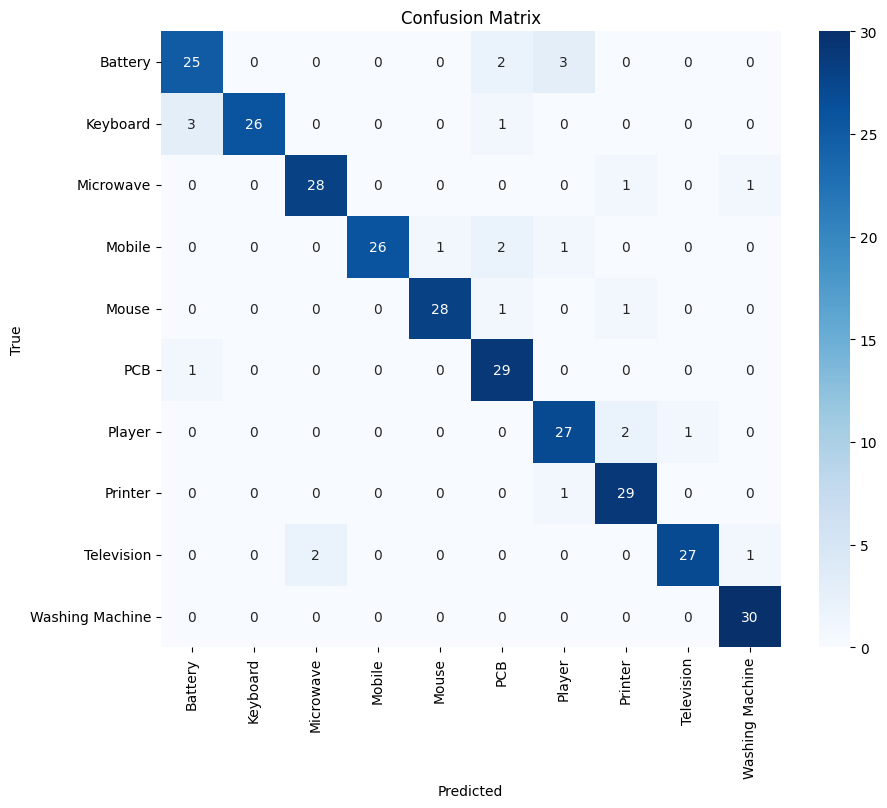

In [28]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


In [29]:
pip install gradio tensorflow pillow numpy


In [30]:
# Save the trained model
model.save('my_image_classifier_model.h5')
print("Model saved successfully as 'my_image_classifier_model.h5'")

Model saved successfully as 'my_image_classifier_model.h5'


In [31]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('my_image_classifier_model.h5')

In [32]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [35]:
# Where you're doing testing/prediction
# Assuming x_test is available and contains your test images
# If not, you might need to extract test images from your test dataset first
# For example:
x_test = np.concatenate([x.numpy() for x, y in datatest], axis=0)

img = x_test[5]
prediction = model.predict(img.reshape(1, 224, 224, 3))
predicted_class = class_names[np.argmax(prediction)]
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Class: Battery


In [36]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4b622e608672240b7b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [39]:
model.save('my_image_classifier_model.keras')

In [40]:
from google.colab import files
files.download('my_image_classifier_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>